In [1]:
from rtlsdr import RtlSdr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
len_in = 1024 * 1500
len_out = int(len_in / 40)

resize = 1 / 40

In [3]:
# increase usb memory buffer
!echo 0 > /sys/module/usbcore/parameters/usbfs_memory_mb

In [4]:
sdr = RtlSdr()

fc = 96700000
fs = 1920000
ppm = 60

sdr.sample_rate = fs
sdr.center_freq = fc
sdr.freq_correction = ppm
sdr.gain = "auto"

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [5]:
num_bytes_to_read = len_in * 2

# raw_data = sdr.read_bytes(num_bytes_to_read)
# print(len(raw_data))
# print(raw_data[0:20])

# raw_uint8 = np.array(raw_data, dtype=np.uint8)
# print(len(raw_uint8))
# print(raw_uint8[0:20])

# raw_int8 = (raw_uint8.astype(np.int16) - 128).astype(np.int8)
# print(len(raw_int8))
# print(raw_int8[0:20])

# packed_samples = raw_int8.view(np.uint16)
# print(len(packed_samples))
# print(packed_samples[0:10])

###########################

complex_samples = sdr.read_samples(len_in)
print(len(complex_samples))
print(complex_samples[0:10])
print(type(complex_samples[0]))

scaled_real = (complex_samples.real * 127).astype(np.int8)
scaled_imag = (complex_samples.imag * 127).astype(np.int8)

interleaved_int8 = np.empty(len(complex_samples) * 2, dtype=np.int8)

interleaved_int8[0::2] = scaled_real
interleaved_int8[1::2] = scaled_imag
print(len(interleaved_int8))
print(interleaved_int8[0:20])

packed_samples = interleaved_int8.view(np.uint16)
print(len(packed_samples))
print(packed_samples[0:10])

#################################

# raw_data = sdr.read_bytes(num_bytes_to_read)
# print(len(raw_data))
# print(raw_data[0:20])

# arr = np.ctypeslib.as_array(raw_data)

# samples = arr.astype(np.float64).view(np.complex128)
# print(len(samples))
# print(samples[0:10])

sdr.close()

1536000
[ 0.00392157+0.01176471j -0.00392157+0.01176471j -0.00392157+0.00392157j
  0.01960784-0.01176471j  0.01176471-0.03529412j  0.00392157-0.01960784j
 -0.00392157+0.01176471j -0.01176471-0.05882353j  0.00392157-0.02745098j
  0.01960784-0.01176471j]
<class 'numpy.complex128'>
3072000
[ 0  1  0  1  0  0  2 -1  1 -4  0 -2  0  1 -1 -7  0 -3  2 -1]
1536000
[  256   256     0 65282 64513 65024   256 63999 64768 65282]


In [6]:
from pynq import Overlay, allocate

ol = Overlay("./overlays/pynq_fm.bit")

In [7]:
print(ol.ip_dict.keys())

dict_keys(['axi_dma_0', 'processing_system7_0'])


In [8]:
dma = ol.axi_dma_0

In [9]:
input_buffer = allocate(shape=(len_in,), dtype=np.uint16)
output_buffer = allocate(shape=(len_out,), dtype=np.int16)

In [10]:
print(f"Input Buffer Address: {hex(input_buffer.device_address)}")
print(f"Output Buffer Address: {hex(output_buffer.device_address)}")

Input Buffer Address: 0x15900000
Output Buffer Address: 0x15860000


In [11]:
np.copyto(input_buffer, packed_samples)
print(input_buffer[0:10])
print(output_buffer[0:10])

[  256   256     0 65282 64513 65024   256 63999 64768 65282]
[0 0 0 0 0 0 0 0 0 0]


In [12]:
dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)

In [13]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=1, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=361758720),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=3072000),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, 

In [14]:
audio_data = output_buffer.astype(np.float32) / 32768.0
print(len(audio_data))
print(audio_data[0:20])
print(output_buffer[0:20])

38400
[-3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -6.1035156e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -6.1035156e-05]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -2 -1 -1 -1 -1 -2]


In [15]:
from IPython.display import Audio

Audio(audio_data, autoplay=True, rate=48000, normalize=False)

In [19]:
del input_buffer, output_buffer

In [16]:
np.save("samples_received", complex_samples)

In [17]:
def downsample(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x) / M)) * M]
    x = x.reshape((int(np.floor(len(x) / M)), M))
    y = x[:,p]
    return y

def fm_discrim(x):
    X = np.real(x)
    Y = np.imag(x)
    b = np.array([1, -1])
    dY = signal.lfilter(b, 1, Y)
    dX = signal.lfilter(b, 1, X)
    discriminated = (X * dY - Y * dX) / (X**2 + Y**2 + 1e-10)
    return discriminated

def fm_audio(samples, fs=1.92e6, fc=96.7e6, fc1=200e3, fc2=50e3, fc3=18e3, d1=5, d2=4, d3=2, plot=False):
    lpf_b1 = signal.firwin(64, fc1/(float(fs)/2))
    lpf_b2 = signal.firwin(64, fc2/(float(fs)/d1/2))
    lpf_b3 = signal.firwin(64, fc3/(float(fs)/d1/d2/2))
    
    # 1st filtering
    samples_filtered_1 = signal.lfilter(lpf_b1, 1, samples)
    # 1st decimation
    samples_decimated_1 = downsample(samples_filtered_1, d1)
    
    # phase discrimination
    samples_discriminated = fm_discrim(samples_decimated_1)
    
    # 2nd filtering
    samples_filtered_2 = signal.lfilter(lpf_b2, 1, samples_discriminated)
    # 2nd decimation
    samples_decimated_2 = downsample(samples_filtered_2, d2)
    
    # 3rd filtering
    samples_filtered_3 = signal.lfilter(lpf_b3, 1, samples_decimated_2)
    # 3rd decimation
    audio = downsample(samples_filtered_3, d3)
    
    if plot:
        fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(4, 2, figsize=(15, 10))

        ax0.psd(samples, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
        ax0.set_title("samples")
        ax0.set_xlabel('Frequency (MHz)')
        ax0.set_ylabel('Relative power (dB)')
        
        ax1.psd(samples_filtered_1, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
        ax1.set_title("samples_filtered_1")
        ax1.set_xlabel('Frequency (MHz)')
        ax1.set_ylabel('Relative power (dB)')

        ax2.psd(samples_decimated_1, NFFT=1024, Fs=fs/d1/1e6, Fc=fc/1e6)
        ax2.title.set_text('samples_decimated_1')
        ax2.set_xlabel('Frequency (MHz)')
        ax2.set_ylabel('Relative power (dB)')

        ax3.psd(samples_discriminated, NFFT=1024, Fs=fs/d1, Fc=0)
        ax3.title.set_text('samples_discriminated')

        ax4.psd(samples_filtered_2, NFFT=1024, Fs=fs/d1, Fc=0)
        ax4.title.set_text('samples_filtered_2')
        
        ax5.psd(samples_decimated_2, NFFT=1024, Fs=fs/d1/d2, Fc=0)
        ax5.title.set_text('samples_decimated_2')
        
        ax6.psd(samples_filtered_3, NFFT=1024, Fs=fs/d1/d2, Fc=0)
        ax6.title.set_text('samples_filtered_3')
        
        ax7.psd(audio, NFFT=1024, Fs=fs/d1/d2/d3, Fc=0)
        ax7.title.set_text('audio')

        plt.show()
        
        return audio, fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7)
    else:
        return audio

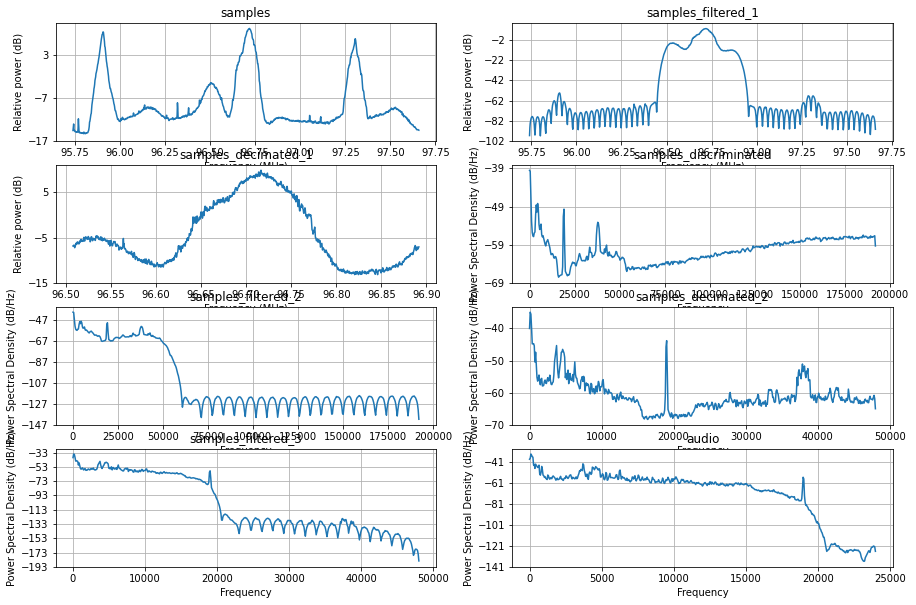

[ 0.00000000e+00  1.30467940e-08  3.23562047e-07 -6.73807203e-07
  2.59086223e-06 -5.64057833e-06 -1.02066468e-04 -5.48400635e-04
 -7.79221912e-04  1.77822390e-03 -2.88525198e-03  2.25546844e-04
  6.09446396e-03 -1.11952509e-02  1.10852657e-02 -1.05785103e-04
 -2.07080729e-02  3.86435460e-02 -3.59613576e-02 -1.06786435e-03]


In [18]:
from IPython.display import Audio

audio, _, _ = fm_audio(complex_samples, plot=True)
print(audio[0:20])
Audio(audio, rate=48000)

In [23]:
sdr.close()